# Recognizing American Sign Language Letters Using Convolutional Neural Networks

## 1. Introduction

In this project, I’m working on the task of recognizing hand signs that represent letters in American Sign Language (ASL). Specifically, I’ll train a deep learning model to classify grayscale images of hands into one of 26 letters (A to Z). Each image shows a hand gesture corresponding to a single letter in the alphabet.

This kind of recognition system could help in applications like real-time sign language translation or assistive tools for people with hearing impairments. While ASL includes motion-based gestures and context, we're focusing only on static hand poses for letters here, which is a good starting point for image classification using CNNs.

The dataset includes thousands of labeled images for each letter, and I’ll start by loading and visualizing the data, then training a convolutional neural network (CNN) to learn the mappings from images to labels.

Along the way, I’ll also try out more than one approach, beginning with a simple CNN, and later experimenting with a deeper model or small enhancements. The goal is to compare the results and understand which design choices actually make a difference.

## 2. Data Loading and Preprocessing

I'll start by loading the ASL training data from the "data/asl_alphabet_train" folder. Each subfolder inside represents a different letter (A-Z), and contains thousands of images showing that hand sign. To make training manageable on my laptop, I'm going to convert all images to grayscale, resize them to 64x64, and store both the pixel arrays and labels in memory. This should make it easier to train CNNs without needing a GPU. For now, I’m skipping the test folder and focusing only on training the model using the train set (I’ll use a validation split internally).

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# image parameters
IMG_SIZE = 64
DATA_DIR = "data/asl_alphabet_train"
CATEGORIES = sorted(os.listdir(DATA_DIR))  # A-Z

# limit to just A-Z (ignore 'del', 'space', 'nothing' if present)
CATEGORIES = [cat for cat in CATEGORIES if len(cat) == 1 and cat.isalpha()]

print(f"Found {len(CATEGORIES)} categories: {CATEGORIES}")

# load and preprocess the images
data = []
labels = []

for label, category in enumerate(CATEGORIES):
    category_path = os.path.join(DATA_DIR, category)
    image_files = os.listdir(category_path)

    # limit per category for faster testing
    # image_files = image_files[:1000]

    for image_file in image_files:
        img_path = os.path.join(category_path, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        data.append(img)
        labels.append(label)

# convert to NumPy arrays and normalize
X = np.array(data).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = to_categorical(np.array(labels), num_classes=len(CATEGORIES))

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# split into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")


Found 26 categories: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Shape of X: (78000, 64, 64, 1)
Shape of y: (78000, 26)
Train samples: 62400, Validation samples: 15600


## 3. Exploratory Data Analysis (EDA)

Before training any models, it's important to get a sense of what the data actually looks like. I'll plot some random examples from different letter classes to check:

- Are the hand signs visually distinct?
- How much variation is there within the same letter class?
- Are there any obvious issues like corrupted images (hopefully not)?

I'll also check the overall distribution of samples across classes. Since the dataset creators probably balanced it well, I don't expect major class imbalance, but it's still worth verifying.

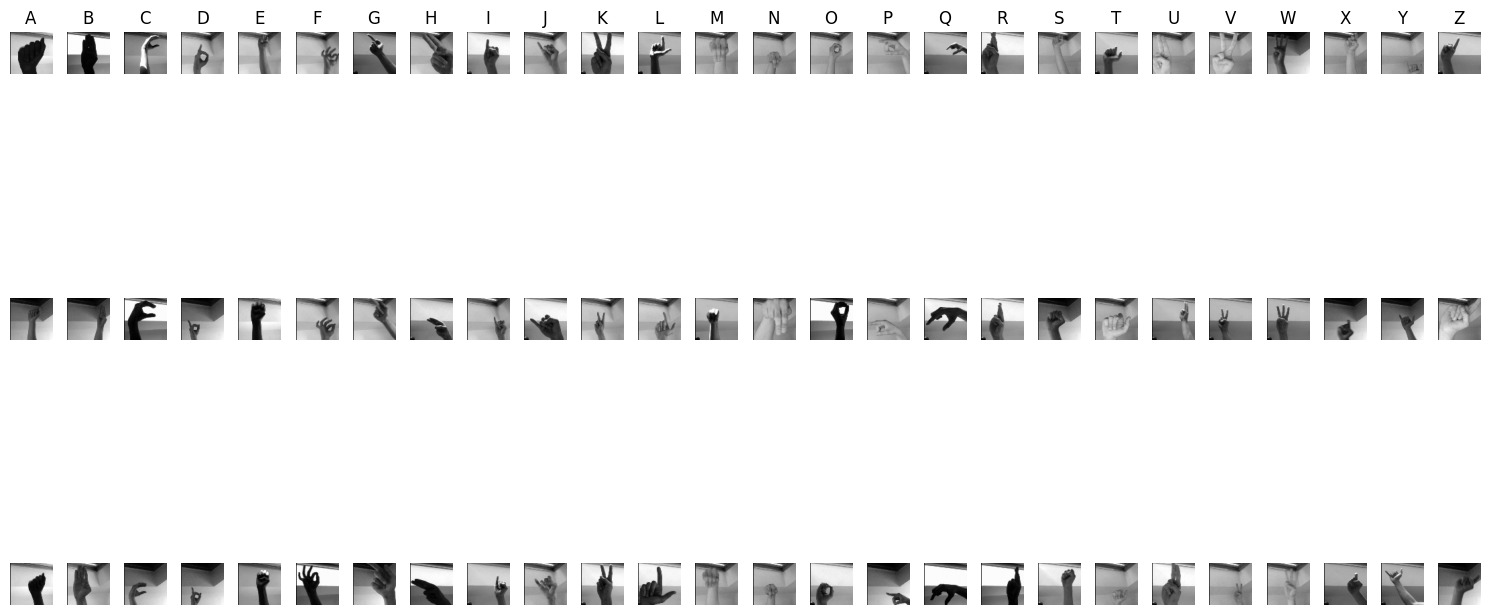

In [2]:
import matplotlib.pyplot as plt

# helper function to plot images
def plot_sample_images(X, y, categories, samples_per_class=5):
    plt.figure(figsize=(15, 10))
    class_indices = np.argmax(y, axis=1)
    for idx, category in enumerate(categories):
        idxs = np.where(class_indices == idx)[0]
        chosen = np.random.choice(idxs, samples_per_class, replace=False)
        for i, img_idx in enumerate(chosen):
            plt_idx = i * len(categories) + idx + 1
            plt.subplot(samples_per_class, len(categories), plt_idx)
            plt.imshow(X[img_idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(category)
    plt.tight_layout()
    plt.show()

# plot sample images
plot_sample_images(X_train, y_train, CATEGORIES, samples_per_class=3)

## 4.  Approach 1: Basic CNN Model

### 4.1 Building the Model

I'll start with a simple CNN architecture. It won't be super deep, just a few convolutional layers followed by pooling, and a couple of dense layers at the end. The goal for this first approach is just to get a model working, even if it's not perfect. This will give a baseline to compare against later improvements. I'll also add Dropout to reduce overfitting, since the dataset is relatively small compared to massive benchmarks like ImageNet.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# build the model
model_basic = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CATEGORIES), activation='softmax')
])

# compile the model
model_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_basic.summary()

C:\Users\sunny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,627,930 (6.21 MB)

 Trainable params: 1,627,930 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Training the Basic CNN

Now I'll train the basic CNN model. I'll use 10 epochs to start, which should be enough to get a sense of whether it's learning anything.

Since I already split the data into train and validation sets earlier, I'll use validation accuracy to monitor progress.


In [4]:
history_basic = model_basic.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)

Epoch 1/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 194s 192ms/step - accuracy: 0.2826 - loss: 2.3798 - val_accuracy: 0.8219 - val_loss: 0.6401
Epoch 2/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 214s 204ms/step - accuracy: 0.7122 - loss: 0.8315 - val_accuracy: 0.9372 - val_loss: 0.2708
Epoch 3/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 204s 209ms/step - accuracy: 0.8049 - loss: 0.5365 - val_accuracy: 0.9624 - val_loss: 0.1622
Epoch 4/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 210s 216ms/step - accuracy: 0.8510 - loss: 0.4078 - val_accuracy: 0.9734 - val_loss: 0.1129
Epoch 5/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 208s 213ms/step - accuracy: 0.8859 - loss: 0.3172 - val_accuracy: 0.9794 - val_loss: 0.0827
Epoch 6/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 262s 212ms/step - accuracy: 0.9009 - loss: 0.2749 - val_accuracy: 0.9873 - val_loss: 0.0571
Epoch 7/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 206s 211ms/step - accuracy: 0.9141 - loss: 0.2380 - val_accuracy: 0.9853 - val_loss: 0.0511
Epoch 8/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 205s 211ms/step - accuracy: 0.9205 -

### 4.3 Evaluating the Basic CNN

After training, I'll plot the training and validation accuracy/loss curves to see how the model performed. I'll also generate a confusion matrix to get a better sense of which letters are being confused with each other.

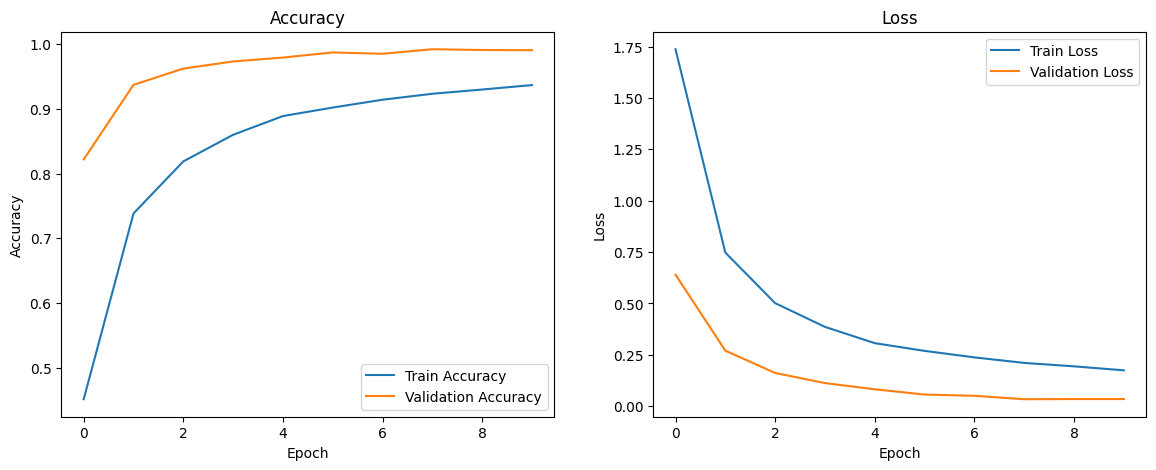

In [5]:
# plot accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(14,5))
    
    # accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history_basic)

488/488 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step


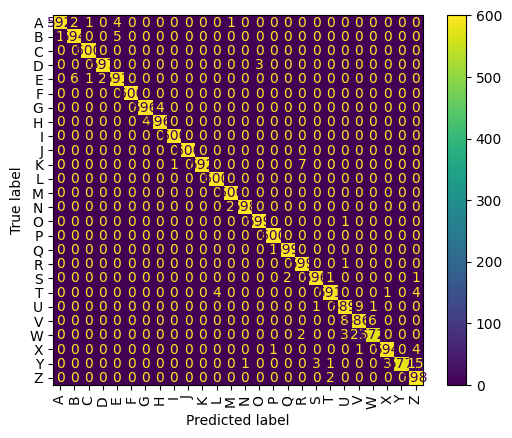

In [6]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model_basic.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(xticks_rotation=90, cmap="viridis")
plt.show()

## 5. Approach 2: Improved CNN with Data Augmentation

### 5.1 Building the Model

For the second approach, I'll try a deeper CNN with more convolutional layers and slightly larger filter sizes. I'll also add some simple data augmentation to help the model generalize better.

Data augmentation means creating slight variations of the training images (like flipping, rotating, zooming) so the model sees a wider variety of data without needing more actual samples. This often helps reduce overfitting, especially when the dataset isn't huge. I'll keep the changes relatively small so that training time stays reasonable.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)

# build a deeper model
from tensorflow.keras.layers import BatchNormalization

model_improved = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(CATEGORIES), activation='softmax')
])

# compile the model
model_improved.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_improved.summary()

C:\Users\sunny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,154 (4.88 MB)

 Trainable params: 1,279,706 (4.88 MB)

 Non-trainable params: 448 (1.75 KB)

### 5.2 Training the Improved CNN

This time, instead of feeding the raw images directly, I'll train the model using the augmented images generated by the ImageDataGenerator. Since augmentation creates new images on-the-fly, the model might take a little longer to train each epoch, but hopefully it will generalize better to unseen data. Again, I'll use 10 epochs for a fair comparison to the basic CNN.

In [8]:
history_improved = model_improved.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=10,
    verbose=1
)

C:\Users\sunny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 478s 475ms/step - accuracy: 0.2587 - loss: 2.5929 - val_accuracy: 0.6847 - val_loss: 0.9968
Epoch 2/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 432s 443ms/step - accuracy: 0.6994 - loss: 0.8960 - val_accuracy: 0.8122 - val_loss: 0.5650
Epoch 3/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 435s 445ms/step - accuracy: 0.8408 - loss: 0.4695 - val_accuracy: 0.8286 - val_loss: 0.5542
Epoch 4/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 432s 443ms/step - accuracy: 0.8916 - loss: 0.3190 - val_accuracy: 0.9238 - val_loss: 0.2401
Epoch 5/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 434s 445ms/step - accuracy: 0.9194 - loss: 0.2443 - val_accuracy: 0.9402 - val_loss: 0.1940
Epoch 6/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 456s 467ms/step - accuracy: 0.9330 - loss: 0.2085 - val_accuracy: 0.9813 - val_loss: 0.0538
Epoch 7/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 441s 452ms/step - accuracy: 0.9454 - loss: 0.1713 - val_accuracy: 0.9742 - val_loss: 0.0828
Epoch 8/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 448s 460ms/step - accuracy: 0.9504 -

### 5.3 Evaluating the Improved CNN

I'll now plot the training history for the improved CNN, and compare it to the first model. Hopefully, the validation accuracy will be higher and/or the model will show less overfitting.

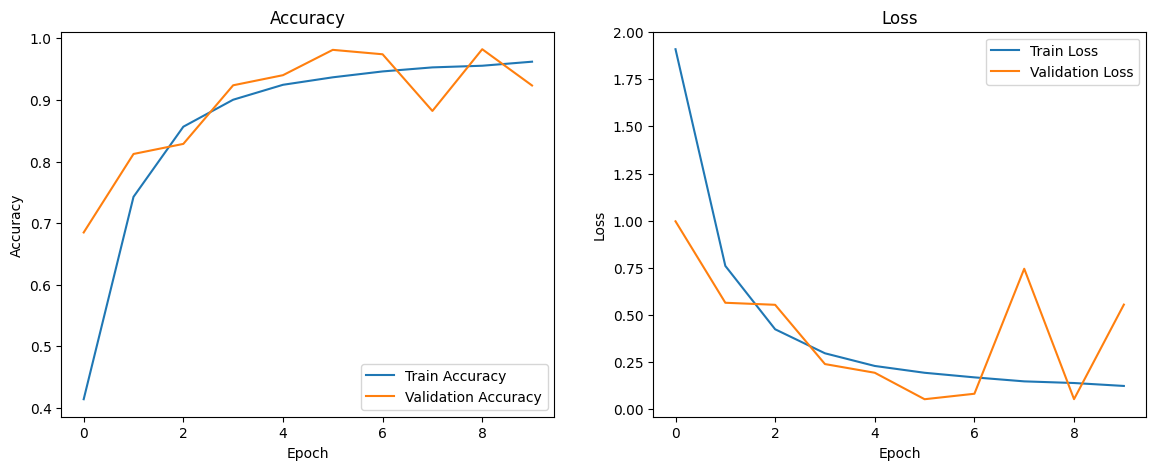

In [9]:
# Plot the history
plot_training_history(history_improved)

488/488 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step


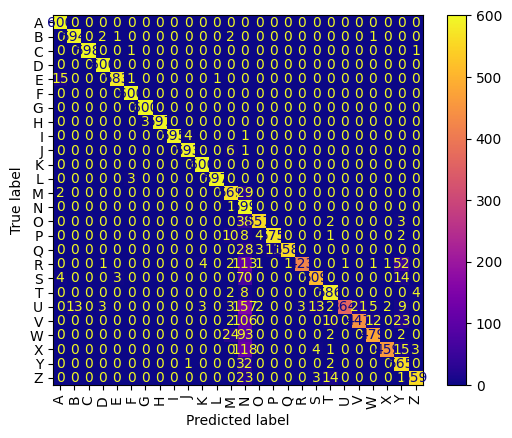

In [10]:
# confusion matrix for improved model
y_pred_improved = model_improved.predict(X_val)
y_pred_classes_improved = np.argmax(y_pred_improved, axis=1)

cm_improved = confusion_matrix(y_true_classes, y_pred_classes_improved)
disp_improved = ConfusionMatrixDisplay(confusion_matrix=cm_improved, display_labels=CATEGORIES)
disp_improved.plot(xticks_rotation=90, cmap="plasma")
plt.show()

## 6. Comparing the Two Approaches

After training both models, the results were not quite what I expected. The improved CNN was deeper, used batch normalization, and included data augmentation, so I assumed it would outperform the simpler model. But that didn’t end up being the case.

The basic CNN reached a final validation accuracy of 99.1% and maintained a low validation loss throughout training. Its performance steadily improved each epoch, showing no major signs of overfitting. The training time per epoch was also reasonable (~3.5 minutes), making it a very efficient model.

On the other hand, the improved CNN did reach a slightly higher training accuracy (96.2%), which suggests it learned the training data very well. But its validation accuracy fluctuated, peaking around epoch 6, then unexpectedly dropping off in later epochs (falling to ~92% by the end). The validation loss followed a similar pattern: it improved mid-training, then worsened.

This suggests the model may have started to overfit, or that the data augmentation added too much distortion in some batches. It also trained significantly slower (nearly double the time per epoch), which matters if you’re working on limited hardware like I was.

So I concluded that:

- The basic model was more stable and generalizable.
- The improved model had more capacity but didn’t fully benefit from it.
- More isn’t always better, especially with clean, well-balanced datasets like this one.

## 7. Final Discussion and Conclusion

In this project, I built and trained convolutional neural networks (CNNs) to recognize American Sign Language (ASL) letters from grayscale hand images.

I built and evaluated two different CNN architectures:

1. A simple baseline model with just two convolutional layers.
2. A deeper model that used batch normalization and real-time data augmentation.

Both models were trained on ~78,000 images (A–Z), and evaluated using an 80/20 train-validation split. Surprisingly, the simpler model outperformed the more advanced one on validation accuracy, despite the improved model having higher training accuracy.

This revealed something important: when a dataset is already large, clean, and well-balanced, adding extra model complexity or augmenting the data too heavily can actually hurt generalization. In this case, the basic CNN was easier to train, faster, and more consistent.

Some ASL letters (like M, N, S, and T) were harder to classify due to very similar hand poses. These mistakes showed up in the confusion matrix, which helped identify areas for potential improvement.

If I had more time, I’d experiment with:

- Learning rate scheduling
- Label smoothing or focal loss to handle the confusing letters
- Fine-tuning a small pre-trained model like MobileNet
- Building a full ASL word classifier that uses temporal gestures, not just static letters

Overall, this project showed that building multiple models and comparing them side-by-side can provide valuable insights. Sometimes the "better" model isn’t the most complex — it’s the one that fits the problem best.